In [83]:
import pandas as pd

validation_df = pd.read_csv('../validation_set.csv')
validation_df = validation_df[['person_id', 'birth_year']]
print(validation_df.head())

   person_id  birth_year
0      62632      1732.0
1      34345      1824.0
2     206202      1542.0
3     142346       635.0
4     131203      1528.0


In [84]:
import pyodbc
import os

def find_mdb_file():
    for root, dirs, files in os.walk("."):
        for file in files:
            if file.endswith(".mdb"):
                return os.path.join(root, file)

mdb_file = find_mdb_file()
print(mdb_file)
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            f'DBQ={mdb_file};')

.\CBDB_20240208_DATA1.mdb


In [85]:
# SELECT c_personid and c_birthyear from BIOG_MAIN to create df

conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
sql = "SELECT c_personid, c_index_year FROM BIOG_MAIN"
cursor.execute(sql)
rows = cursor.fetchall()
biog_main_df = pd.DataFrame.from_records(rows, columns=['person_id', 'index_year'])
biog_main_df.head()

,person_id,index_year
0,0,NaN
1,1,1042.0
2,2,0.0
3,3,1065.0
4,4,955.0


In [86]:
biog_main_validation_df = biog_main_df.merge(validation_df, on='person_id', how='inner')
biog_main_validation_df.head()

,person_id,index_year,birth_year
0,259,973.0,962.0
1,318,999.0,985.0
2,829,976.0,963.0
3,924,1023.0,1030.0
4,971,1027.0,1027.0


In [87]:
# Using biog_main_validation_df['index_year'] not NaN to calculate recall
recall = biog_main_validation_df['index_year'].notna().sum() / len(validation_df)
biog_main_validation_df = biog_main_validation_df.dropna()

In [88]:
from sklearn.metrics import r2_score
biog_main_validation_df['index_year'] = biog_main_validation_df['index_year'].astype(int)
biog_main_validation_df['birth_year'] = biog_main_validation_df['birth_year'].astype(int)
biog_main_validation_df['diff'] = abs(biog_main_validation_df['index_year'] - biog_main_validation_df['birth_year'])
biog_main_validation_df['diff_abs'] = biog_main_validation_df['diff'].abs()
biog_main_validation_df['diff_square'] = biog_main_validation_df['diff'] ** 2
biog_main_validation_df['diff_abs'].mean()
biog_main_validation_df['diff_std'] = biog_main_validation_df['index_year'].std()
r2 = r2_score(biog_main_validation_df['index_year'], biog_main_validation_df['birth_year'])

# print recall, precision, RMSE, MAE
rmse = biog_main_validation_df['diff_square'].mean() ** 0.5
mae = biog_main_validation_df['diff_abs'].mean()
# print(f'recall: {recall}')
print(f'MAE: {rmse}')
print(f'RMSE: {mae}')
print(f'R2: {r2}')
print(f'STD: {biog_main_validation_df["diff_std"].mean()}')

MAE: 159.95510733839154
RMSE: 31.145703611457037
R2: 0.852460556943477
STD: 416.56165855544583


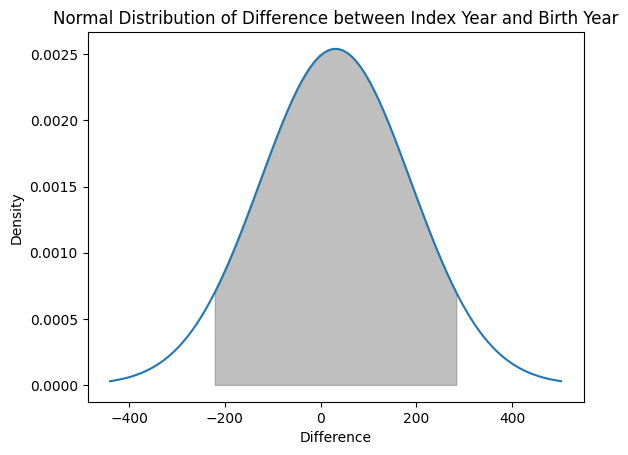

In [89]:
# Draw a normal curve for the diff

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

mu = biog_main_validation_df['diff'].mean()
sigma = biog_main_validation_df['diff'].std()
# grey the 90% area
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.fill_between(x, y, where=(x > mu - 1.645*sigma) & (x < mu + 1.645*sigma), color='grey', alpha=0.5)
plt.title('Normal Distribution of Difference between Index Year and Birth Year')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.show()


In [90]:
# What is the percent of data that is within 10 years of the true birth year?
biog_main_validation_df['diff_abs_10'] = biog_main_validation_df['diff_abs'] <= 10
percent_within_10 = biog_main_validation_df['diff_abs_10'].sum() / len(biog_main_validation_df)
print(f'percent within 10 years: {percent_within_10}')

percent within 10 years: 0.651307596513076


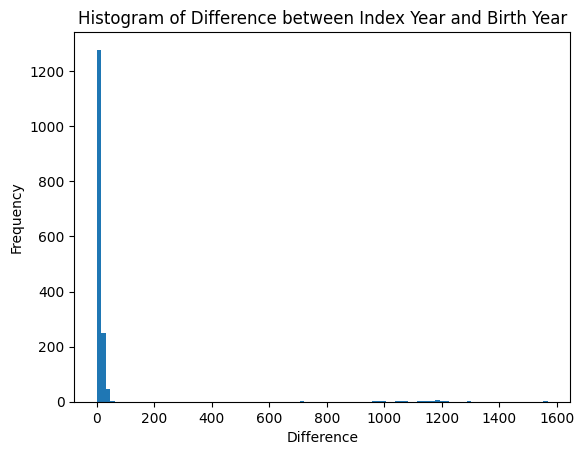

In [91]:

plt.hist(biog_main_validation_df['diff'], bins=100)

plt.title('Histogram of Difference between Index Year and Birth Year')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

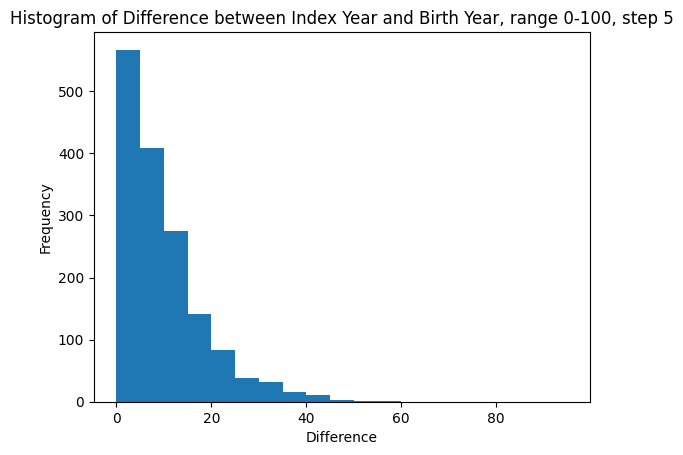

In [92]:
# Draw the histogram of the diff
# set x range to 0-100, group is 5
plt.hist(biog_main_validation_df['diff'], bins=range(0, 100, 5))
plt.title('Histogram of Difference between Index Year and Birth Year, range 0-100, step 5')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [93]:
biog_main_validation_df.to_excel('biog_main_validation_df.xlsx', index=False)

In [94]:
biog_main_validation_df.shape

(1606, 8)